In [1]:
import numpy as np
import pandas as pd
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, BatchNormalization, Reshape, LeakyReLU
from keras.optimizers import Adam
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

/home/ejrueda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
X_train = pd.read_csv("./data/ClustREFGenes-master/Data/Core_genome/Data_Core_Genome_Ecoli_log2.csv",
                  index_col=0)
print("Dimensionalidade dos dados: ", X_train.shape)
X_train.head()

Dimensionalidade dos dados:  (4051, 9)


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
Genes,,,,,,,,,
accD,6.875411,7.047582,7.431765,7.105877,6.516094,6.676126,6.304694,6.168221,6.245553
aceF,7.732412,7.674997,8.397717,7.455056,7.277269,6.525536,7.455730,6.403830,7.597941
ackA,7.231720,7.260976,8.033280,6.921924,6.920829,6.556644,6.358150,5.888768,6.359310
agaV,6.048825,6.250033,5.120269,5.559767,5.915593,6.279490,6.441998,6.553099,6.105364
alaS,7.811728,7.853890,8.622037,7.636451,7.641365,7.125920,7.164957,6.555678,7.098590


- vou trocar a dimensionalidade de cada gen, por uma dimesionalidade de 3x3, para assim ver o gen como uma imagem.

In [53]:
X_img = np.array(X_train).reshape((X_train.shape[0],3,3))
X_lab = X_train.index

----------------------------- Genomas representados na forma de uma imagem -----------------------------


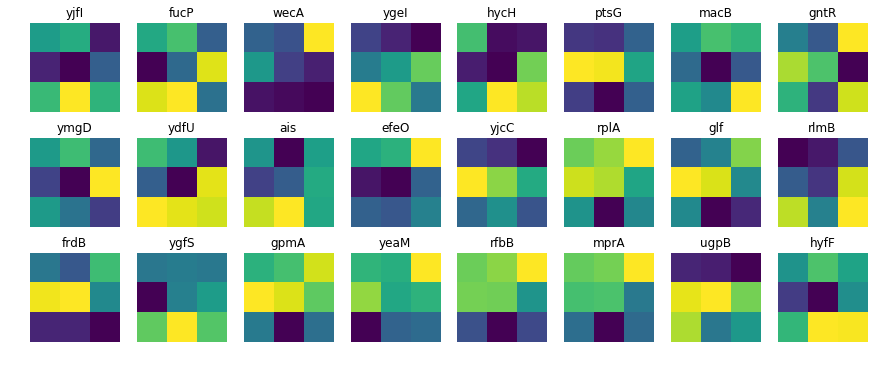

In [65]:
idx = np.random.randint(low=0, high=X_train.shape[0], size=24)
imgs =  X_img[idx]
titles = X_lab[idx]
fig = plt.figure(figsize=(15,6))
p=0
#plt.title("Genomas representados na forma de uma imagem", fontsize=12)
plt.axis("off");
print("----------------------------- Genomas representados na forma de uma imagem -----------------------------")
for i in imgs:
    ax=fig.add_subplot(3,8,p+1)
    plt.title(titles[p])
    plt.imshow(i)
    plt.axis("off");
    p += 1

In [ ]:
class GANs():
    #inialização dos parâmetros
    def __init__(self, width, height, channels, noise_input):
        self.width = width
        self.height = height
        self.channels = channels
        self.dim = (self.width, self.height, self.channels)
        self.noise_input = noise_input
        self.g_loss = []
        self.d_loss = []
        #self.optimizer = Adam(lr=0.0001, beta_1=0.5)
        self.optimizer1 = Adam(lr=0.00001, beta_1=0.5)
        self.optimizer2 = Adam(lr=0.00001, beta_1=0.5)
        self.G = self.noise_generator()
        print("Compilando o gerador...")
        self.G.compile(loss='binary_crossentropy', optimizer=self.optimizer2)
        self.D = self.discriminator()
        print("Compilando o discriminador...")
        self.D.compile(loss='binary_crossentropy', optimizer=self.optimizer1, metrics=['accuracy'])
        self.stacked_generator_discriminator = Sequential()
        self.stacked_generator_discriminator.add(self.G)
        self.stacked_generator_discriminator.add(self.D)
        self.D.trainable = False
        self.stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer2)
        
    #criação do gerador de imagens fake
    def noise_generator(self):
        model = Sequential()
        model.add(Dense(2*2*512, input_shape=(self.noise_input,)))
        model.add(Reshape((2,2,512)))
        model.add(Conv2DTranspose(filters=512, kernel_size=(5,5), strides=(2,2), padding="same"))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Conv2DTranspose(filters=256, kernel_size=(5,5), strides=(2,2), padding="same"))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(2,2), padding="same"))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Conv2DTranspose(filters=64, kernel_size=(3,3), strides=(2,2), padding="same"))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Conv2DTranspose(filters=3, kernel_size=(3,3), strides=(1,1), padding="same", activation="tanh"))
        
        return model
    
    #criação do discriminador
    def discriminator(self):
        model = Sequential()
        model.add(Conv2D(filters=64, kernel_size=(5,5), strides=(2,2), padding="same", input_shape=self.dim))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Conv2D(filters=128, kernel_size=(5,5), strides=(2,2), padding="same"))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(2,2), padding="same"))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding="same"))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        return model
    
    #Para obter o sumary do gerador
    def summary_gerador(self):
        return self.G.summary()
    
    #Para obter o sumary do gerador
    def summary_discriminador(self):
        return self.D.summary()
        
    #pra obter os batches pra o treino
    def get_batches(self, X_train, batch_size):
        """
        X_train: dataset para o treino
        epochs: quantidade de epocas para o treino do gradiente
        batch: tamanho to batch pra o treino de cada epochs
        """
        batches = []
        num_bat = int(np.ceil(X_train.shape[0]/batch_size))
        lim_i = 0
        lim_s = batch_size
        for i in range(num_bat):
            if lim_s > X_train.shape[0]:
                lim_s = X_train.shape[0]
            batches.append(X_train[lim_i:lim_s])
            lim_i += batch_size
            lim_s += batch_size
            
        return batches
        
    #devolve o loss do gerador e do discriminador
    def get_loss(self):
        return [self.g_loss, self.d_loss]
    
    #treinamento da GAN
    def train(self, X_train, epochs, batch_size):
        self.d_loss = []
        self.g_loss = []
        batches = self.get_batches(X_train, batch_size)
        for cnt in range(epochs):
            count_b = 0
            t_i = time()
            for batch in batches:
                gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), self.noise_input))
                #gerando as imagens fake
                syntetic_images = self.G.predict(gen_noise)
                #criação do array de treinamento
                x_combined_batch = np.concatenate((batch, syntetic_images))
                y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                                   np.zeros((batch.shape[0], 1))))
                #treino do discriminador
                d_l = self.D.train_on_batch(x_combined_batch, y_combined_batch)
                self.d_loss.append(d_l[0])

                # train generator
                noise = np.random.normal(0, 1, (batch.shape[0], self.noise_input))
                y_mislabled = np.ones((batch.shape[0], 1))

                g_l = self.stacked_generator_discriminator.train_on_batch(noise, y_mislabled)
                self.g_loss.append(g_l)
                count_b += 1
                if (count_b%10)==0:
                    t_f = time()
                    t = t_f - t_i
                    t_i = time()
                    print ('epoch:[%d/%d] batch:[%d/%d], [Discriminator::d_loss: %f], [Generator::loss: %f], %d[sec]'
                               % (cnt+1,epochs,count_b,len(batches),d_l[0],g_l,t))